In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import cut_tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from scipy import signal

%load_ext autoreload
%autoreload 2

# Import data

In [2]:
df_motifs = pd.read_csv('df_motifs_features.tsv')
df_motifs

,id,seq_len,gravy,tiny,small,aliphatic,aromatic,non_polar,polar,charged,basic,acidic,helix,turn,sheet
0,GHWT,4,-1.300000,0.500000,0.500000,0.00,0.500000,0.500000,0.500000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000
1,GHWTQ,5,-1.740000,0.400000,0.400000,0.00,0.400000,0.400000,0.600000,0.200000,0.200000,0.000000,0.200000,0.200000,0.000000
2,HWT,3,-1.600000,0.333333,0.333333,0.00,0.666667,0.333333,0.666667,0.333333,0.333333,0.000000,0.333333,0.000000,0.000000
3,HWTQ,4,-2.075000,0.250000,0.250000,0.00,0.500000,0.250000,0.750000,0.250000,0.250000,0.000000,0.250000,0.000000,0.000000
4,PGNV,4,-0.325000,0.250000,0.750000,0.25,0.000000,0.750000,0.250000,0.000000,0.000000,0.000000,0.250000,0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,VHAA,4,1.150000,0.500000,0.750000,0.75,0.250000,0.750000,0.250000,0.250000,0.250000,0.000000,0.250000,0.000000,0.500000
194,VKSY,4,-0.450000,0.250000,0.500000,0.25,0.250000,0.500000,0.500000,0.250000,0.250000,0.000000,0.500000,0.250000,0.000000
195,KTD,3,-2.700000,0.333333,0.000000,0.00,0.000000,0.000000,1.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.000000
196,DKE,3,-3.633333,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,1.000000,0.333333,0.666667,0.000000,0.000000,0.333333


# The functions

In [3]:
def features_data_scaling(df_features, scaling_method):
    """features_data_scaling
       ---------------------
       This function scales data from 
       feature calculation.
       
       Arguments:
       df_features -- pandas dataframe with 
                      values of features
       scaling_method -- 0 or 1
                         where 0 -> standard scaling
                         where 1 -> minmax scaling
                         where 2 -> robust scaling

       Output:
       df_features_scl -- pandas dataframe with 
                        scaled values of features
    """
    ### Creates a copy of the original dataframe
    #
    df_features_scl = df_features.copy()

    ### Drop duplicated lines (e.g. seqs that are present several times)
    #
    df_features_scl = df_features_scl.drop_duplicates()

    ### Set the id as index
    #
    df_features_scl.set_index('id', inplace=True)

    ### Rescale the data
    #
    #   Here, we use a Standard Scaling
    if scaling_method == 0: 
        df_features_scl = pd.DataFrame(
            StandardScaler().fit_transform(df_features_scl),
            index=df_features_scl.index, columns=df_features_scl.columns
        )
    
    #   Here, we use a MinMax Scaling
    if scaling_method == 1:
        df_features_scl = pd.DataFrame(
            MinMaxScaler().fit_transform(df_features_scl),
            index=df_features_scl.index, columns=df_features_scl.columns
        )
    
    #   Here, we use a Robust Scaling
    if scaling_method == 2:
        df_features_scl = pd.DataFrame(
            RobustScaler().fit_transform(df_features_scl),
            index=df_features_scl.index, columns=df_features_scl.columns
        )
    
    return df_features_scl

In [4]:
def dendogram_of_motifs(link_matrix, df_motifs_scl, best_distance):
    """dendogram_of_motifs
       -------------------
       This function generates the dendogram 
       of the clustered motifs.
       
       Arguments:
       link_matrix -- linkage matrix of clustering
       df_motifs_scl -- pandas dataframe of 
                        motifs' scaled feature values.
       best_distance -- distance at which the cut of the tree in CLUMPs
                        is performed.
       
       Output:
       dendogram -- figure of the dendogram
    """
    dendogram = plt.figure(figsize=(12, 30))
    dend = shc.dendrogram(link_matrix, 
                         labels=df_motifs_scl.index,
                         leaf_font_size=10, 
                         orientation='right',
                         color_threshold= best_distance)
    plt.axvline(x=best_distance)
    plt.title("Dendrogram of motifs", fontsize=25);
    
    return dendogram

In [5]:
def db_score(link_matrix, nb_distances, df_motifs_scl):
    """db_score
       --------
       This function calculates the davies bouldin score
       for a given number of intervals of distances (nb_distances)
       
       Arguments:
       link_matrix -- linkage matrix of clustering,
       nb_distances -- number of intervals of distances at which
                       calculate the davies bouldin score 
       df_motifs_scl -- pandas dataframe of 
                        motifs' scaled feature values.
                        
       Output:
       
       dict_davies_bouldin_results -- all the distances tested and the
                                      corresponding davies bouldin score
    """
    # Calculate maximum distance in distance matrix.
    max_dist = shc.maxdists(link_matrix).max()
    # Calculate nb_distances
    possible_distances = np.linspace(1, max_dist, nb_distances)

    # Iterate on all the distances to perform the cut
    dict_davies_bouldin_results = {}
    X = np.array(df_motifs_scl)
    for distance in possible_distances:

        # create a df with CLUMPs obtained at that distance
        
        motifs_CLUMPs = pd.DataFrame(
            {'motif':df_motifs_scl.index, 'CLUMP':cut_tree(
                link_matrix, height= distance).ravel()})
        labels = np.array(motifs_CLUMPs.CLUMP)
        db_index = davies_bouldin_score(X, labels)
        dict_davies_bouldin_results.update({distance: db_index})
    
    return dict_davies_bouldin_results

In [6]:
def calculate_df_motifs_CLUMPs_of_best_cut(link_matrix, nb_distances, df_motifs_scl):
    """calculate_df_motifs_CLUMPs_of_best_cut
       --------------------------------------
       This function iterates on the possible distances of CLUMPs 
       for the tree cut and calculates the corresponding davies_bouldin_score.
       Then, returns the dataframe df_motifs_CLUMPs calculated
       using the best distance.
    
       Arguments: 
       link_matrix -- linkage matrix of clustering
       nb_distances -- number of intervals of distances at which
                       calculate the davies bouldin score 
       df_motifs_scl -- pandas dataframe of 
                        motifs' scaled feature values.
    
       Output:
       dict_davies_bouldin_results -- all the distances tested and the
                                      corresponding davies bouldin score.
       best_distance -- best distance for the 
                        cutting of the tree 
                        according to the calculated function.
       df_motifs_CLUMPs -- pandas dataframe of motifs and CLUMPs.
    
    """

    dict_davies_bouldin_results = db_score(link_matrix, nb_distances, df_motifs_scl)
    
    # Find first local minimum in dict_davies_bouldin_results
    x = np.array(list(dict_davies_bouldin_results.values()))
    min_peakind = signal.find_peaks_cwt(1/x, np.arange(1,10))
    best_davies = x[min_peakind][0]
    # extract best distance by best db score
    distances = list(dict_davies_bouldin_results.keys())
    db_scores = list(dict_davies_bouldin_results.values())
    position = db_scores.index(best_davies)
    best_distance = distances[position]

    # Create df using the best distance
    df_motifs_CLUMPs = pd.DataFrame(
        {'motif':df_motifs_scl.index,
         'CLUMP':cut_tree(link_matrix, height = best_distance).ravel()})
    
    return best_distance, df_motifs_CLUMPs, dict_davies_bouldin_results


In [7]:
def get_newick(node, parent_dist, leaf_names, newick='') -> str:
    """
    Convert sciply.cluster.hierarchy.to_tree()-output to Newick format.

    :param node: output of sciply.cluster.hierarchy.to_tree()
    :param parent_dist: output of sciply.cluster.hierarchy.to_tree().dist
    :param leaf_names: list of leaf names
    :param newick: leave empty, this variable is used in recursion.
    :returns: tree in Newick format
    """
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parent_dist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parent_dist - node.dist, newick)
        else:
            newick = ");"
        newick = get_newick(node.get_left(), node.dist, leaf_names, newick=newick)
        newick = get_newick(node.get_right(), node.dist, leaf_names, newick=",%s" % (newick))
        newick = "(%s" % (newick)
        return newick

In [8]:
def to_newick(df_motifs, link_matrix):
    tree = shc.to_tree(link_matrix, False)
    leaf_names= df_motifs.index
    newick_tree= get_newick(tree, tree.dist, leaf_names)
    return newick_tree

In [9]:
def motif_clustering(df_motifs_scl, nb_distances):
    """motif_clustering
       ----------------
       This function performs a 
       hierarchical/agglomerative clustering 
       on the motifs.
       
       Then it converts the tree in newick format.
       
       Then it calculates the best distance to cut
       the tree to obtain the CLUMPs 
       (cluster of motifs of proteins). 
       To do that it uses the davies_bouldin score.
       
       Then it cuts the tree into CLUMPs.
       
       Arguments:
       df_motifs_scl -- pandas dataframe of 
                        motifs' scaled feature values 
       nb_distances -- number of intervals of distances at which
                       calculate the davies bouldin score 
       
       Output:
       link_matrix -- linkage matrix of motifs.
       dict_davies_bouldin_results -- all the distances tested and the
                                      corresponding davies bouldin score
       df_motifs_CLUMPs -- pandas dataframe of the motifs
                           and the correspondant CLUMP
       dendogram -- dendogram of the clustered motifs
                           
       
    """
    
    ### Clustering (creation of the linkage matrix using the method ward)
    #
    link_matrix = shc.linkage(df_motifs_scl, method='ward')
    

    ### Iterating on the possible distances of CLUMPs for the 
    ### tree cut and calculate corresponding davies_bouldin_score
    #
    best_distance, df_motifs_CLUMPs, dict_davies_bouldin_results = calculate_df_motifs_CLUMPs_of_best_cut(
        link_matrix, nb_distances, df_motifs_scl)
    
    # Generate dendogram of motifs, with CLUMPs obtained cutting
    # at the best_distance
    dendogram = dendogram_of_motifs(link_matrix, df_motifs_scl, best_distance)
    
    ### Getting Newick format of tree
    newick_tree = to_newick(df_motifs_scl, link_matrix)
    
    return link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree

# Different nb_distances tests

In [10]:
df_motifs_scl = features_data_scaling(df_motifs, 2)

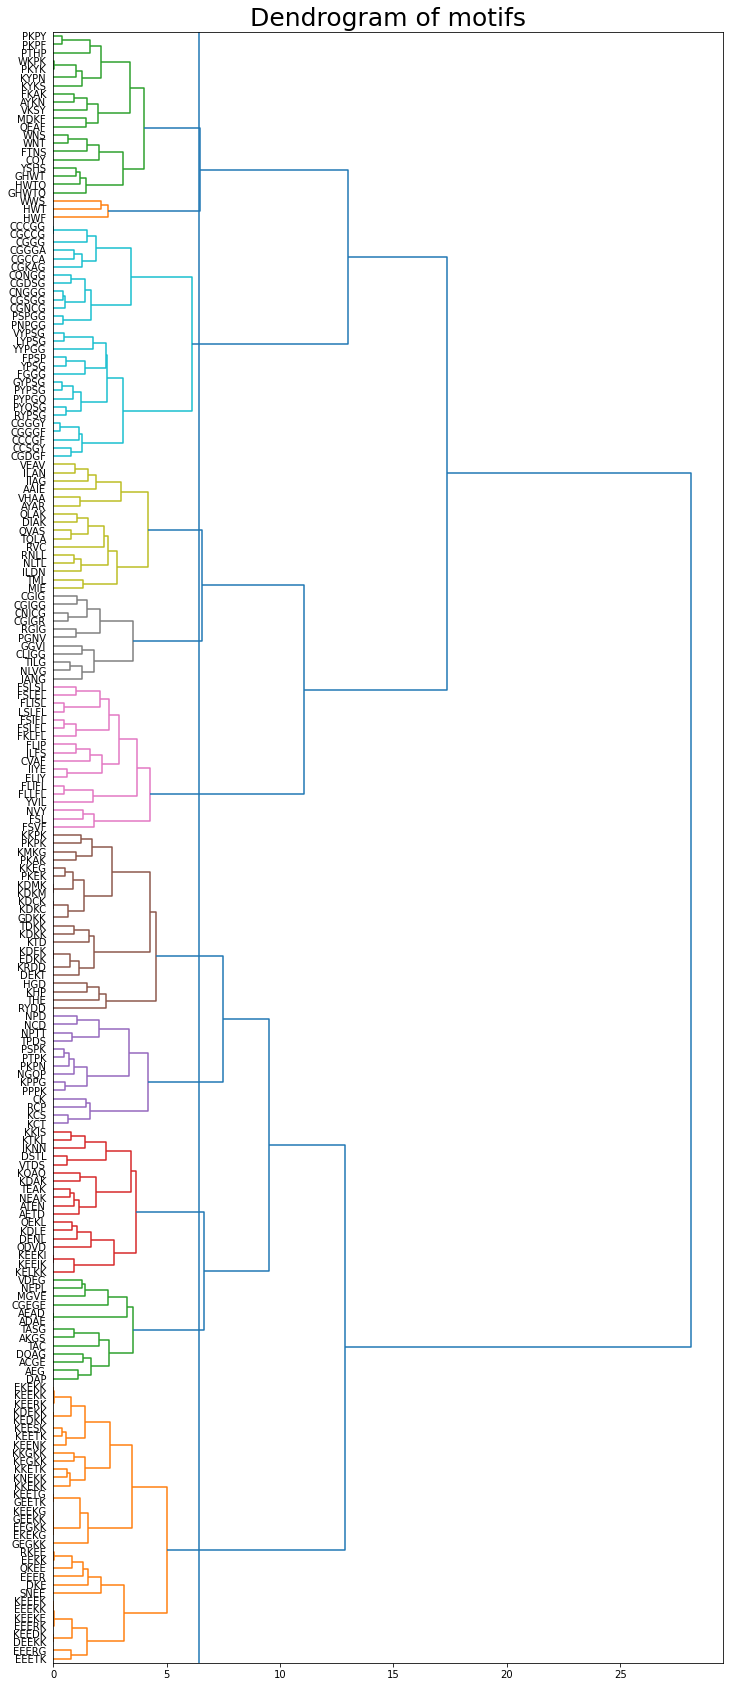

In [47]:
# 6
link_matrix_6, best_distance_6, dict_davies_bouldin_results_6, df_motifs_CLUMPs_6, dendogram_6, newick_tree_6 = motif_clustering(df_motifs_scl, 6)

In [48]:
df_motifs_CLUMPs_6.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

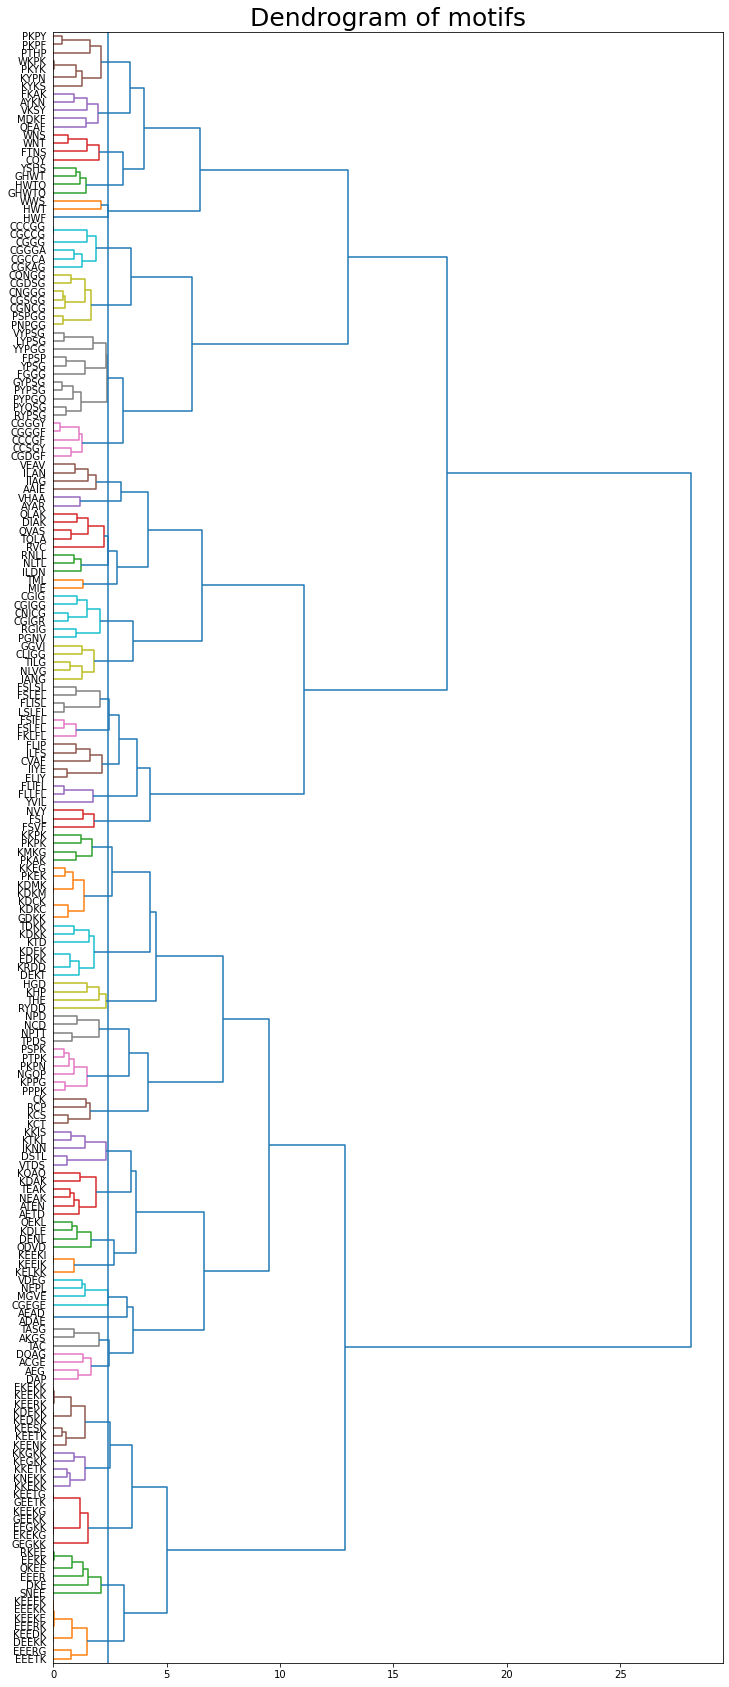

In [13]:
# 20
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 20)

In [14]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41])

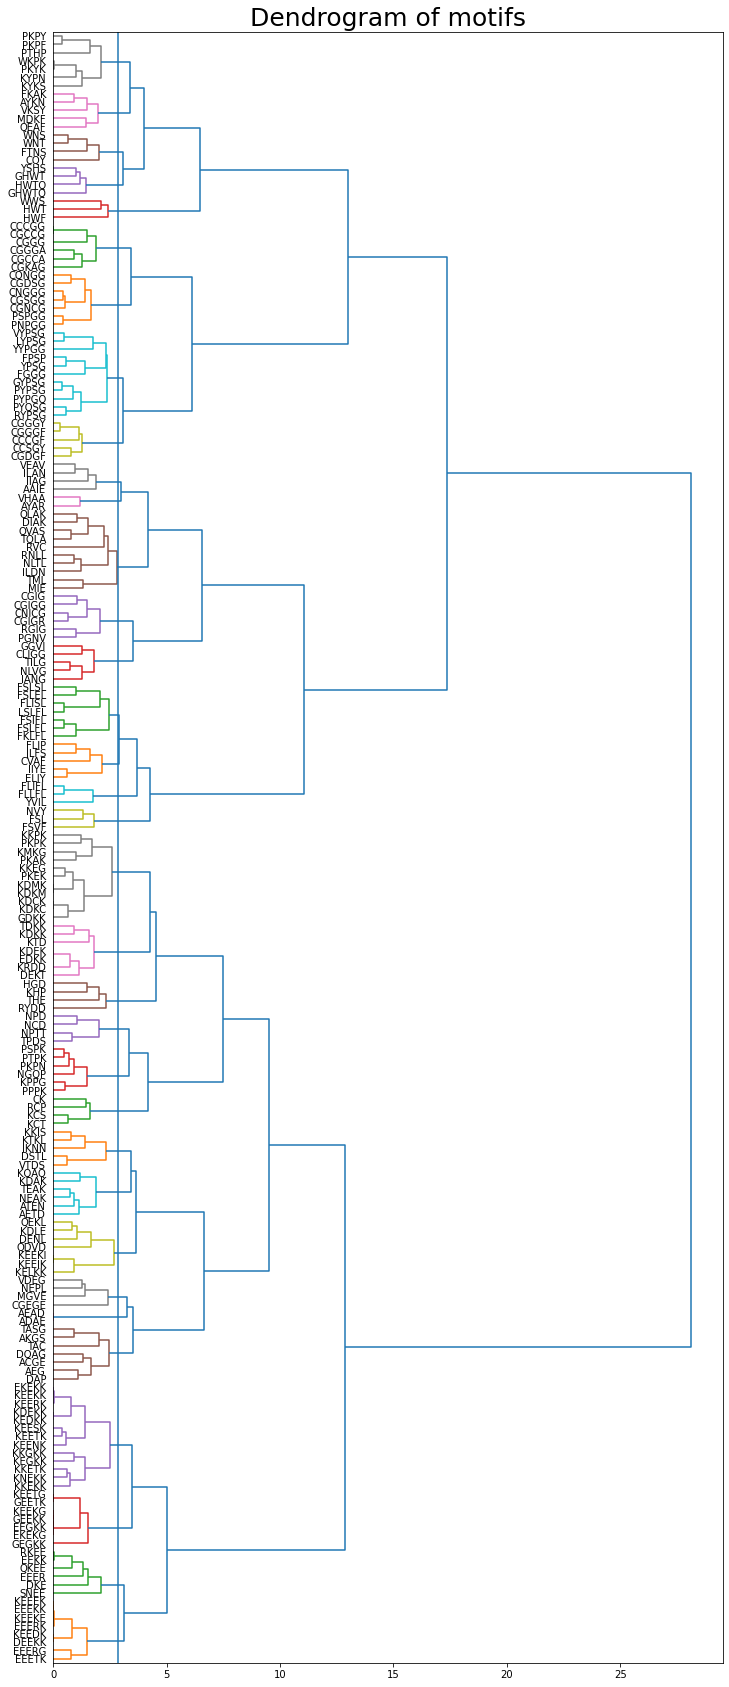

In [15]:
# 30
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 30)

In [16]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

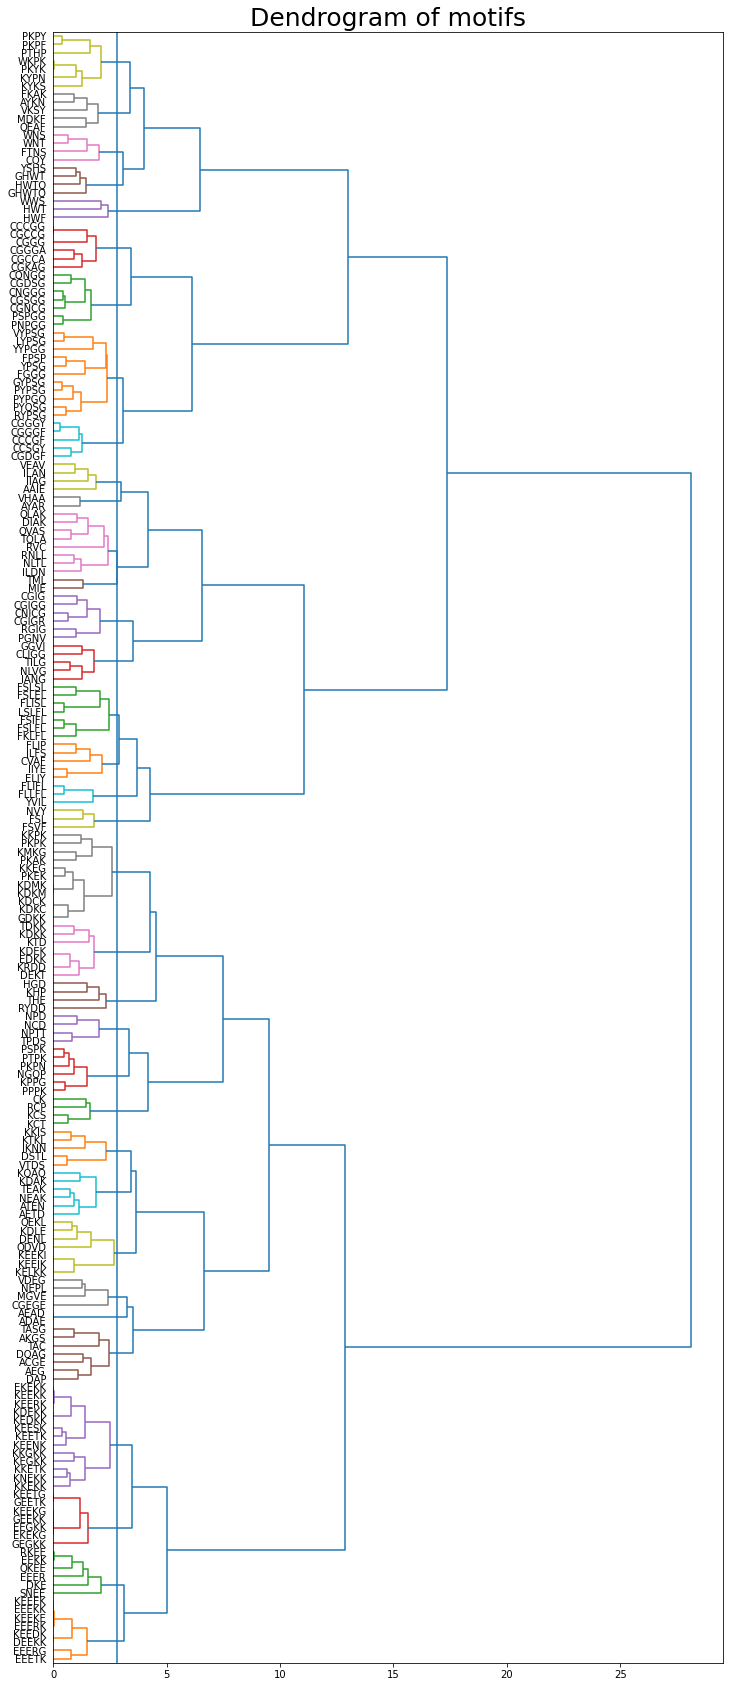

In [17]:
# 31
link_matrix_31, best_distance_31, dict_davies_bouldin_results_31, df_motifs_CLUMPs_31, dendogram_31, newick_tree_31 = motif_clustering(df_motifs_scl, 31)

In [18]:
df_motifs_CLUMPs_31.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

> Based on the number of CLUMPs obtained, a number of intervals of 31 is reasonable

In [19]:
print('CLUMP 0')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 0]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 0].motif)

CLUMP 0
4


['GHWT', 'GHWTQ', 'HWTQ', 'YSHS']

In [20]:
print('CLUMP 1')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 1]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 1].motif)

CLUMP 1
3


['HWT', 'WWS', 'HWF']

In [21]:
print('CLUMP 2')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 2]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 2].motif)

CLUMP 2
6


['PGNV', 'CGIGG', 'CGIGR', 'CNICG', 'CGIG', 'RGIG']

In [22]:
print('CLUMP 3')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 3]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 3].motif)

CLUMP 3
11


['PKPK',
 'KDKC',
 'KDKM',
 'KDCK',
 'PKEK',
 'KDMK',
 'GDKK',
 'KKPK',
 'PKAK',
 'KMKG',
 'KKEG']

In [23]:
print('CLUMP 4')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 4]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 4].motif)

CLUMP 4
7


['PTHP', 'PKYK', 'WKPK', 'PKPF', 'PKPY', 'KYKS', 'KYPN']

In [24]:
print('CLUMP 5')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 5]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 5].motif)

CLUMP 5
2


['ADAE', 'AEAD']

In [25]:
print('CLUMP 6')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 6]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 6].motif)

CLUMP 6
8


['TQLA', 'DIAK', 'NLTL', 'QLAK', 'RVC', 'ILDN', 'RNLL', 'QVAS']

In [26]:
print('CLUMP 7')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 7]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 7].motif)

CLUMP 7
11


['YPSG',
 'PYPGQ',
 'PYPSG',
 'GYPSG',
 'RYPSG',
 'LYPSG',
 'YYPGG',
 'VYPSG',
 'PYQSG',
 'FGGG',
 'FPSP']

In [27]:
print('CLUMP 8')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 8]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 8].motif)

CLUMP 8
6


['CGCCG', 'CCCGG', 'CGCCA', 'CGGGA', 'CGKAG', 'CGGG']

In [28]:
print('CLUMP 9')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 9]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 9].motif)

CLUMP 9
13


['KEEKK',
 'KEGKK',
 'KKEKK',
 'KNEKK',
 'KEERK',
 'KEETK',
 'EKEKK',
 'KKGKK',
 'KKETK',
 'KEENK',
 'KEDKK',
 'KDEKK',
 'KEESK']

In [29]:
print('CLUMP 10')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 10]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 10].motif)

CLUMP 10
7


['FSLFL', 'FSLEL', 'FKLFL', 'FSLSL', 'FSIFL', 'LSLFL', 'FLISL']

In [30]:
print('CLUMP 11')
print(len(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 11]))
list(df_motifs_CLUMPs_31[df_motifs_CLUMPs_31['CLUMP'] == 11].motif)

CLUMP 11
8


['EEEKK', 'EEERK', 'EEETK', 'DEEKK', 'KEEEK', 'EEERG', 'KEEDK', 'KEEKE']

## Other tests

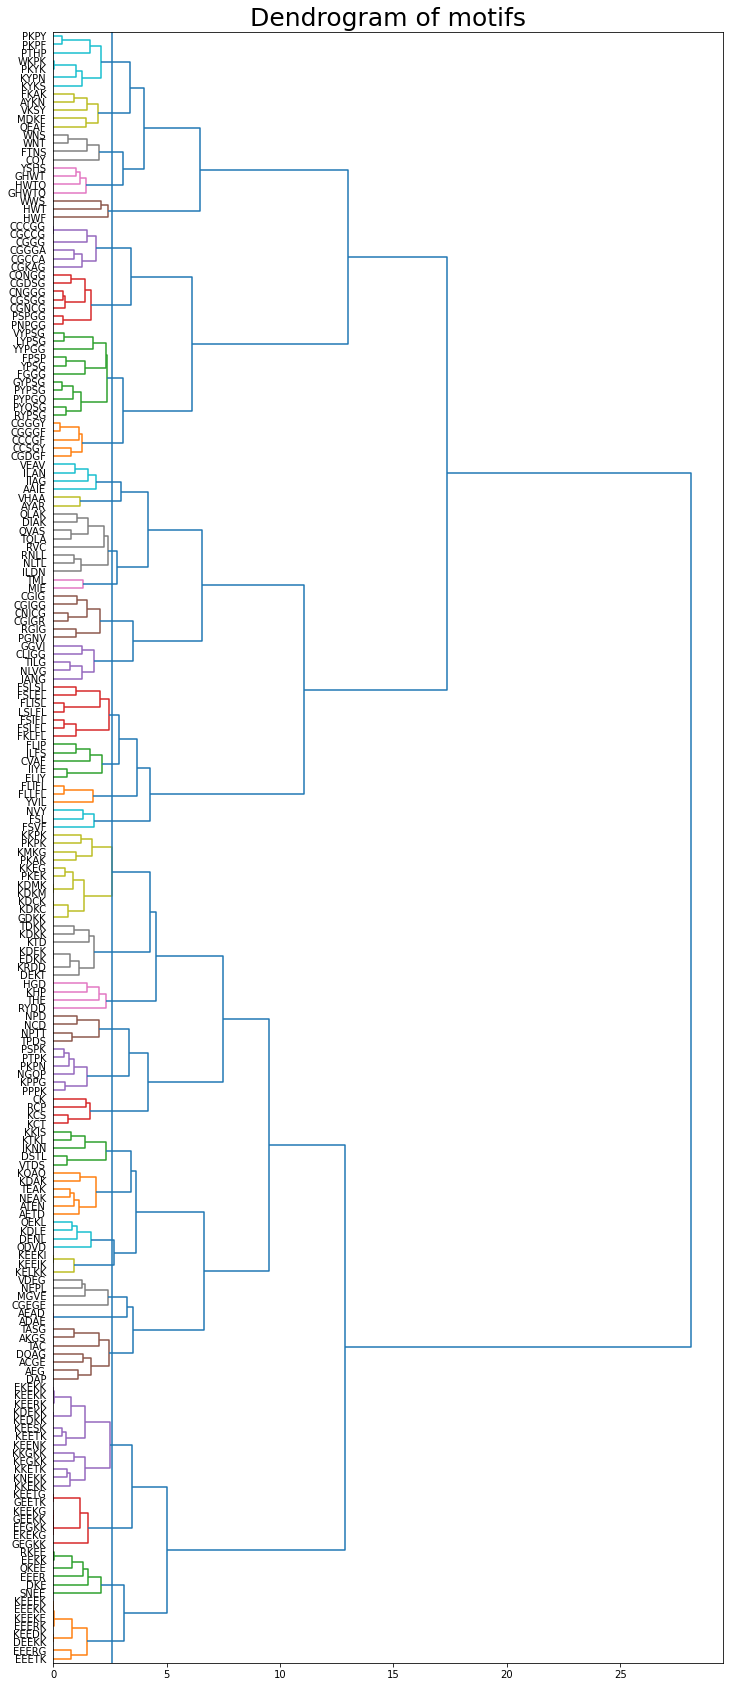

In [31]:
# 35
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 35)

In [32]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

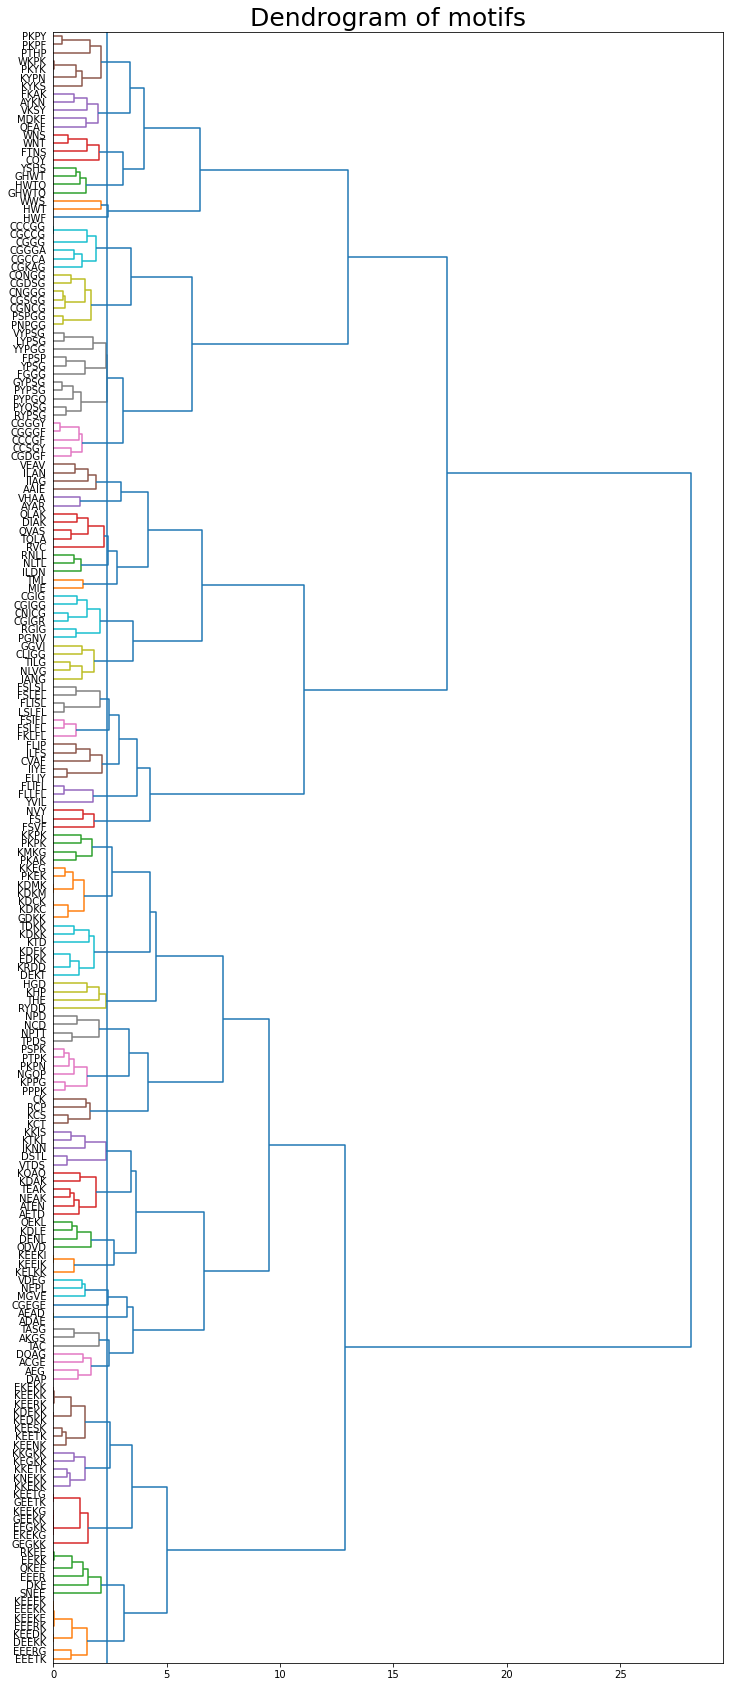

In [33]:
# 40
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 40)

In [34]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

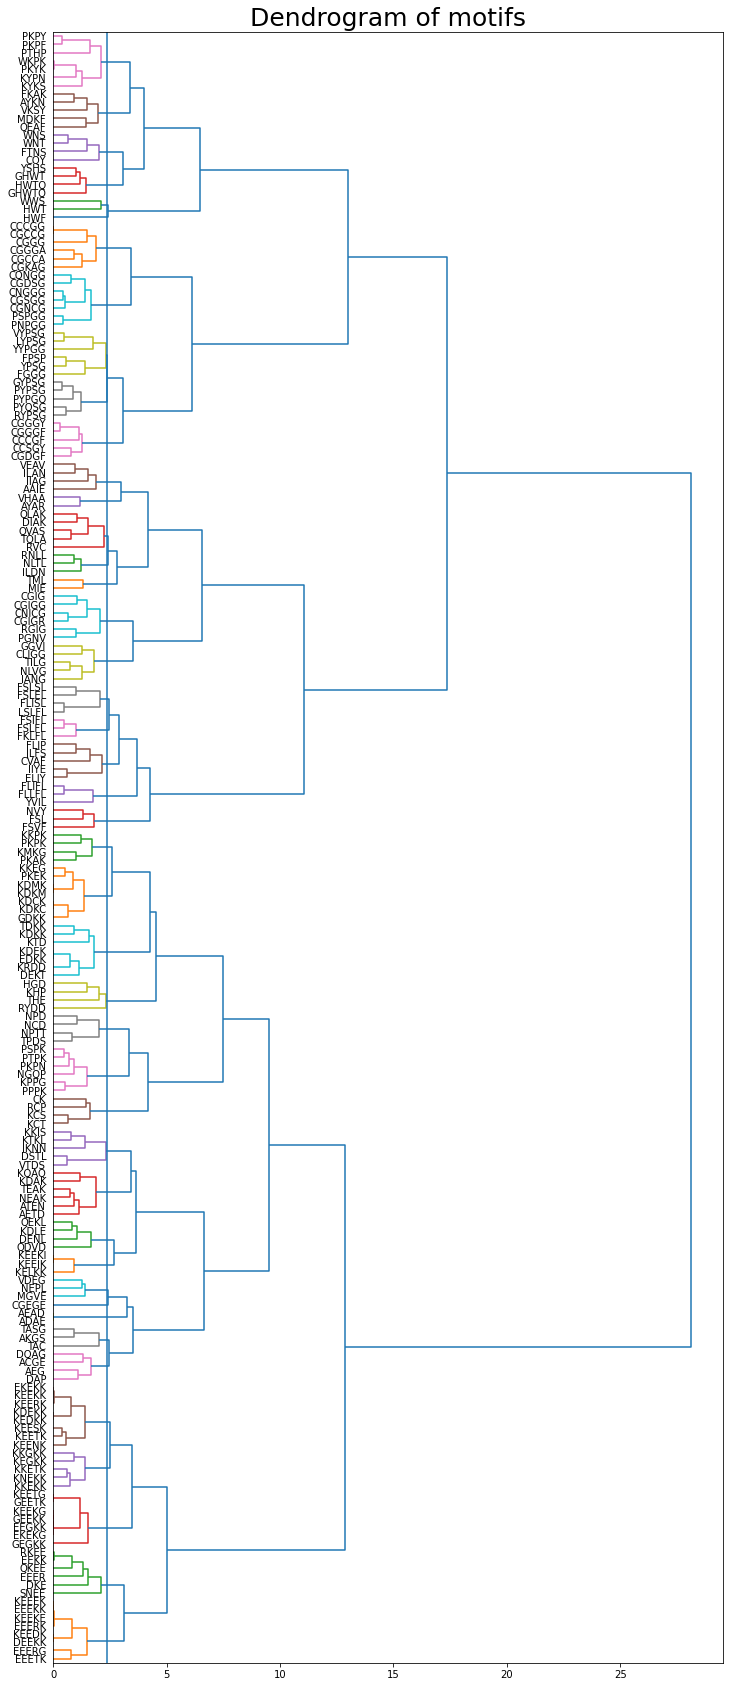

In [35]:
# 41
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 41)

In [36]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

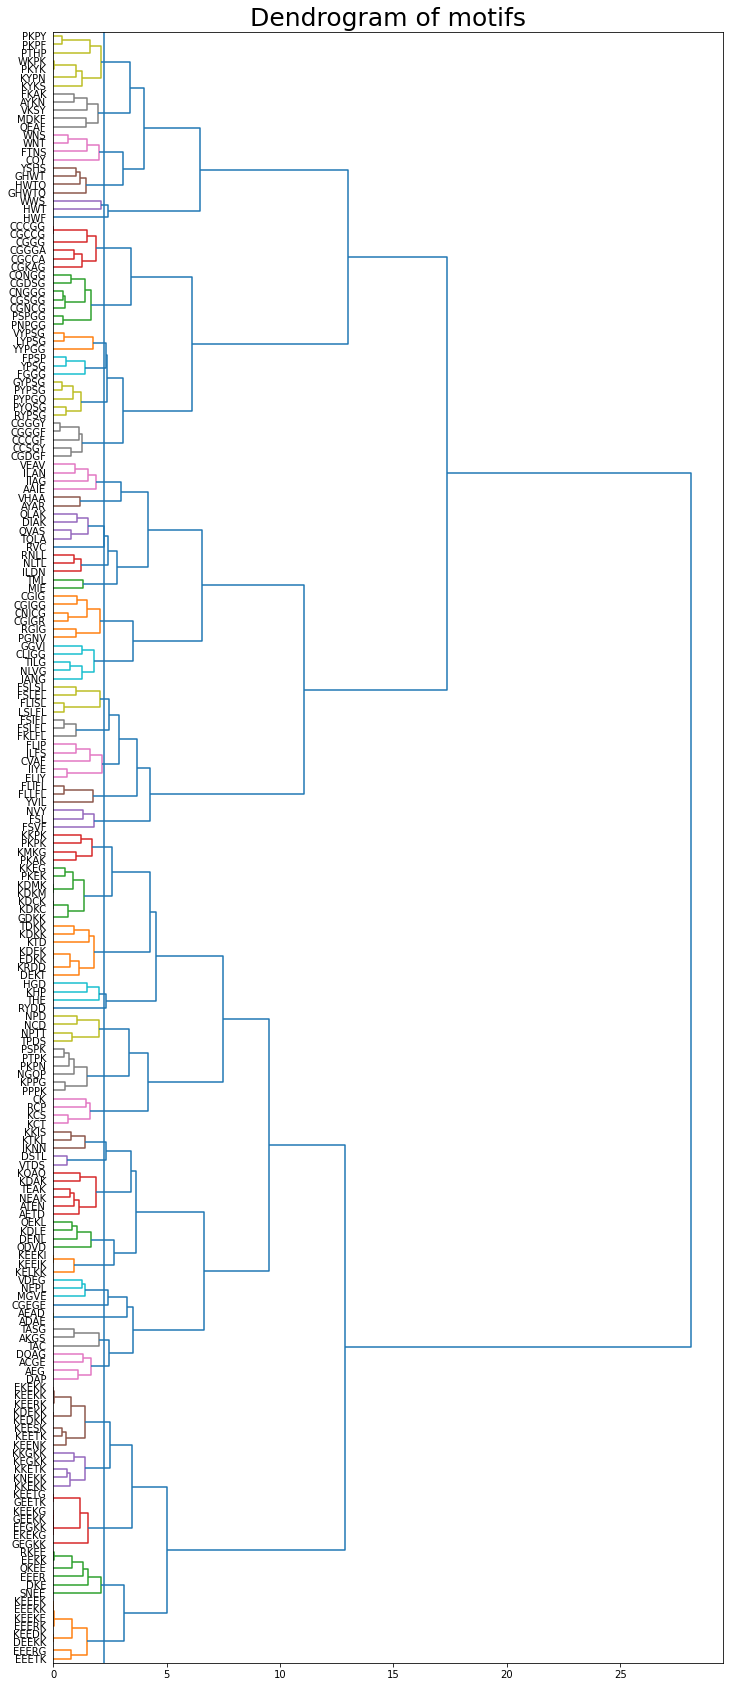

In [37]:
# 45
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 45)

In [38]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

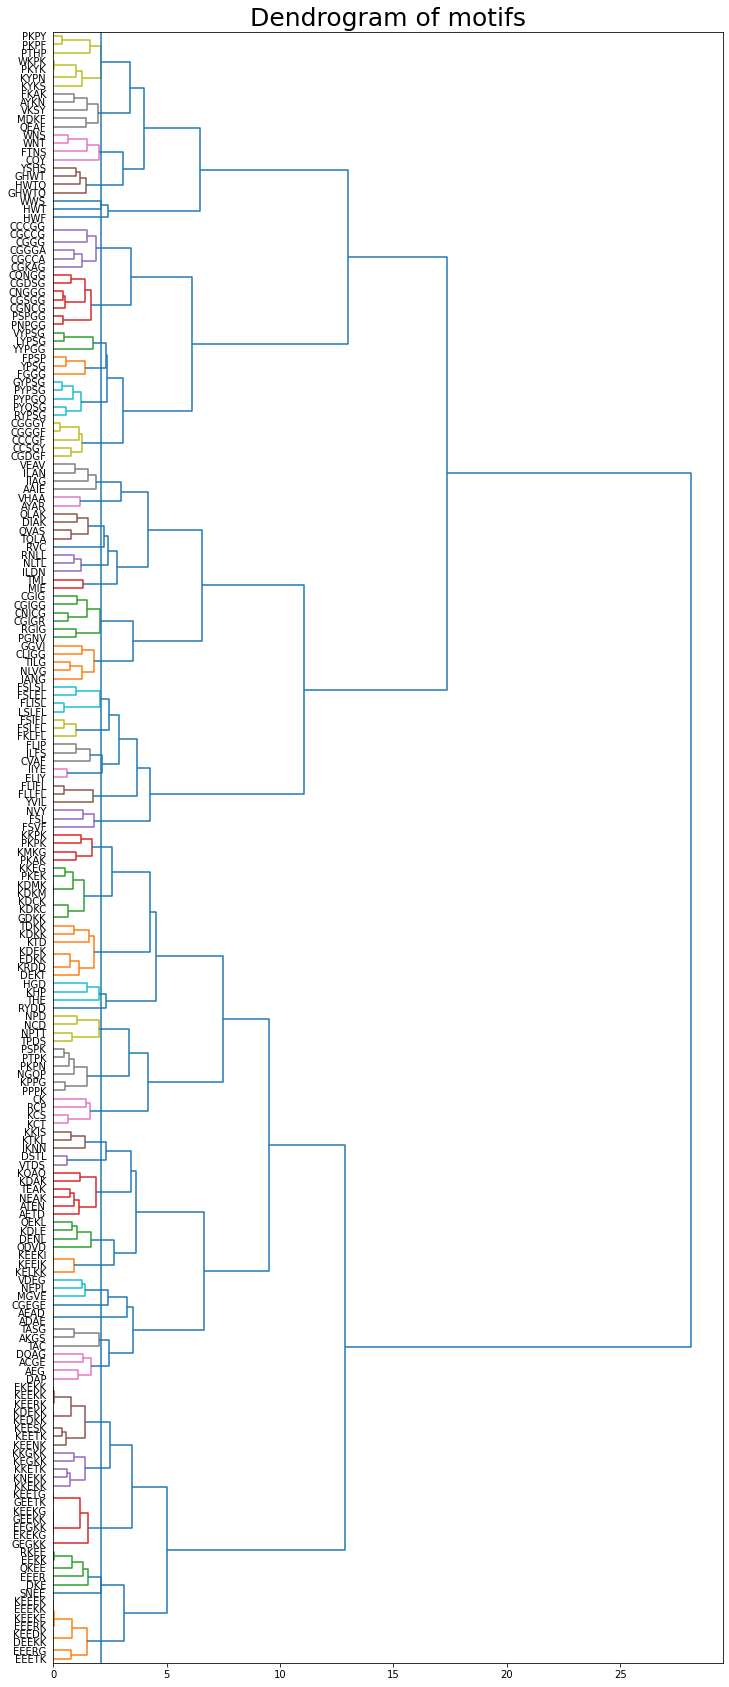

In [39]:
# 50
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 50)

In [40]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

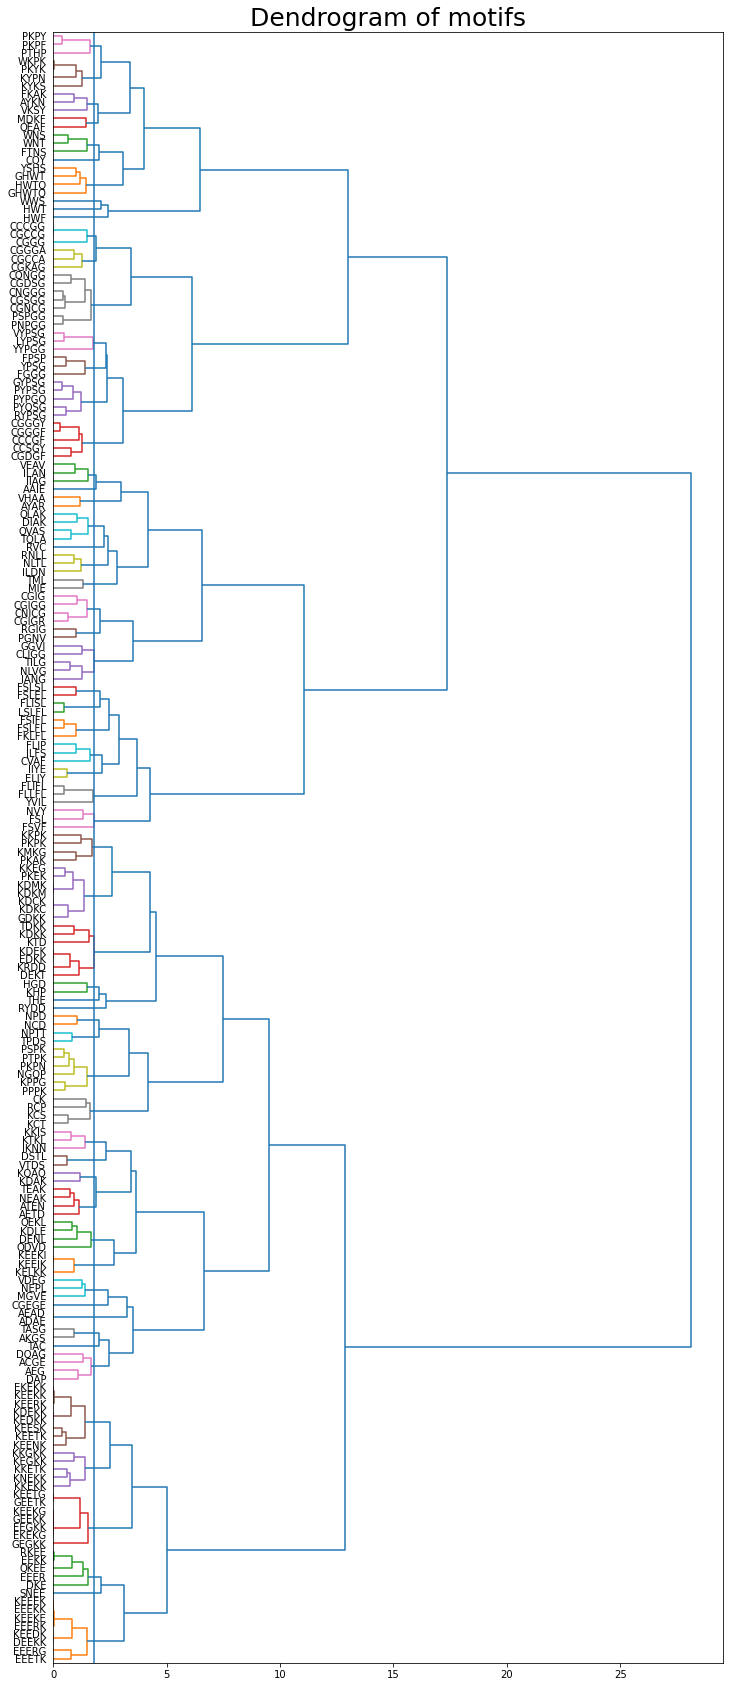

In [41]:
# 100
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 100)

In [42]:
df_motifs_CLUMPs.CLUMP.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

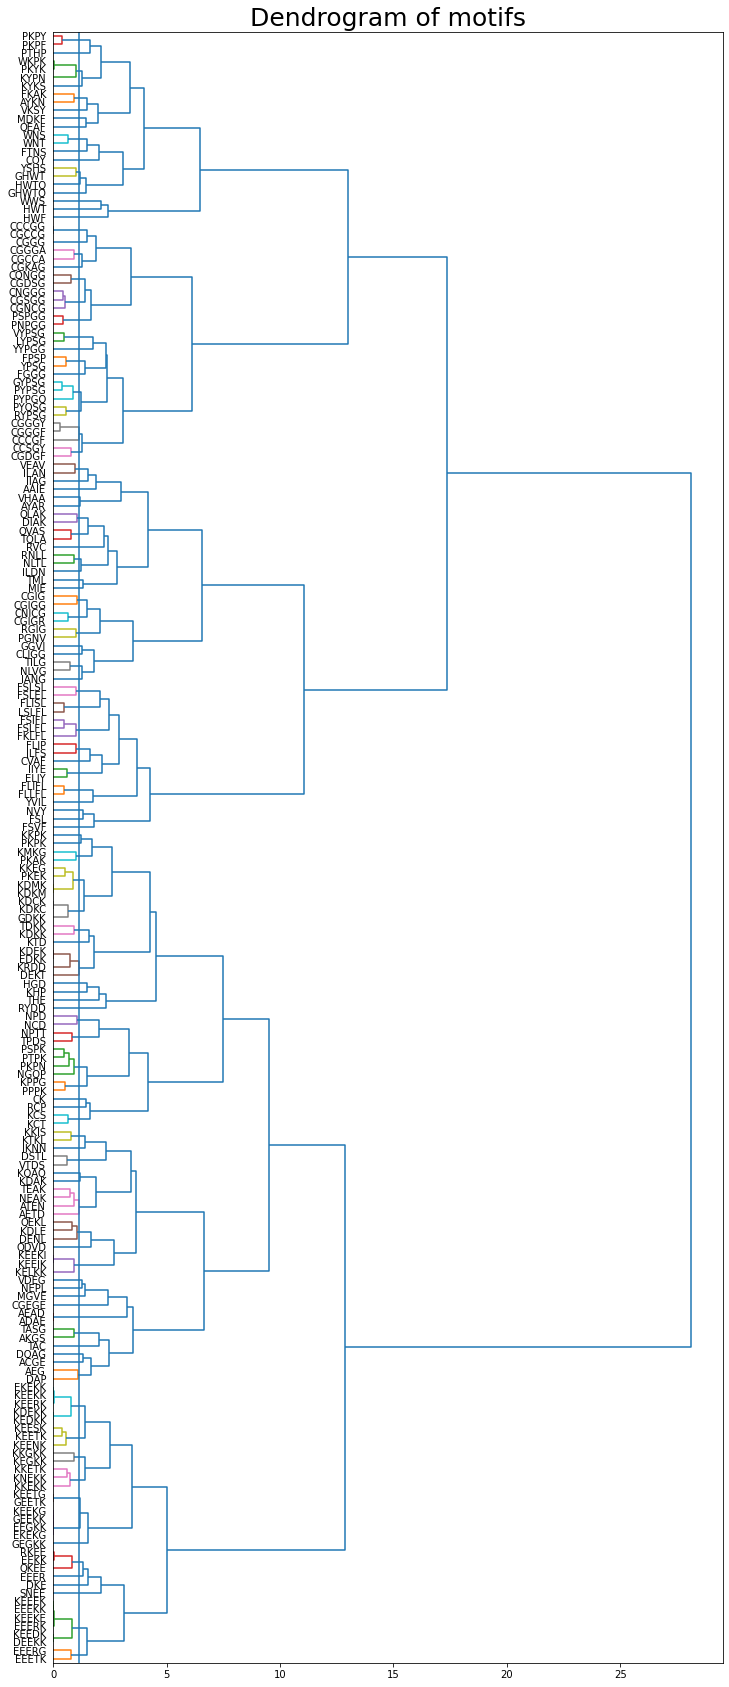

In [43]:
# 500
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 500)

In [44]:
df_motifs_CLUMPs.CLUMP.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112])

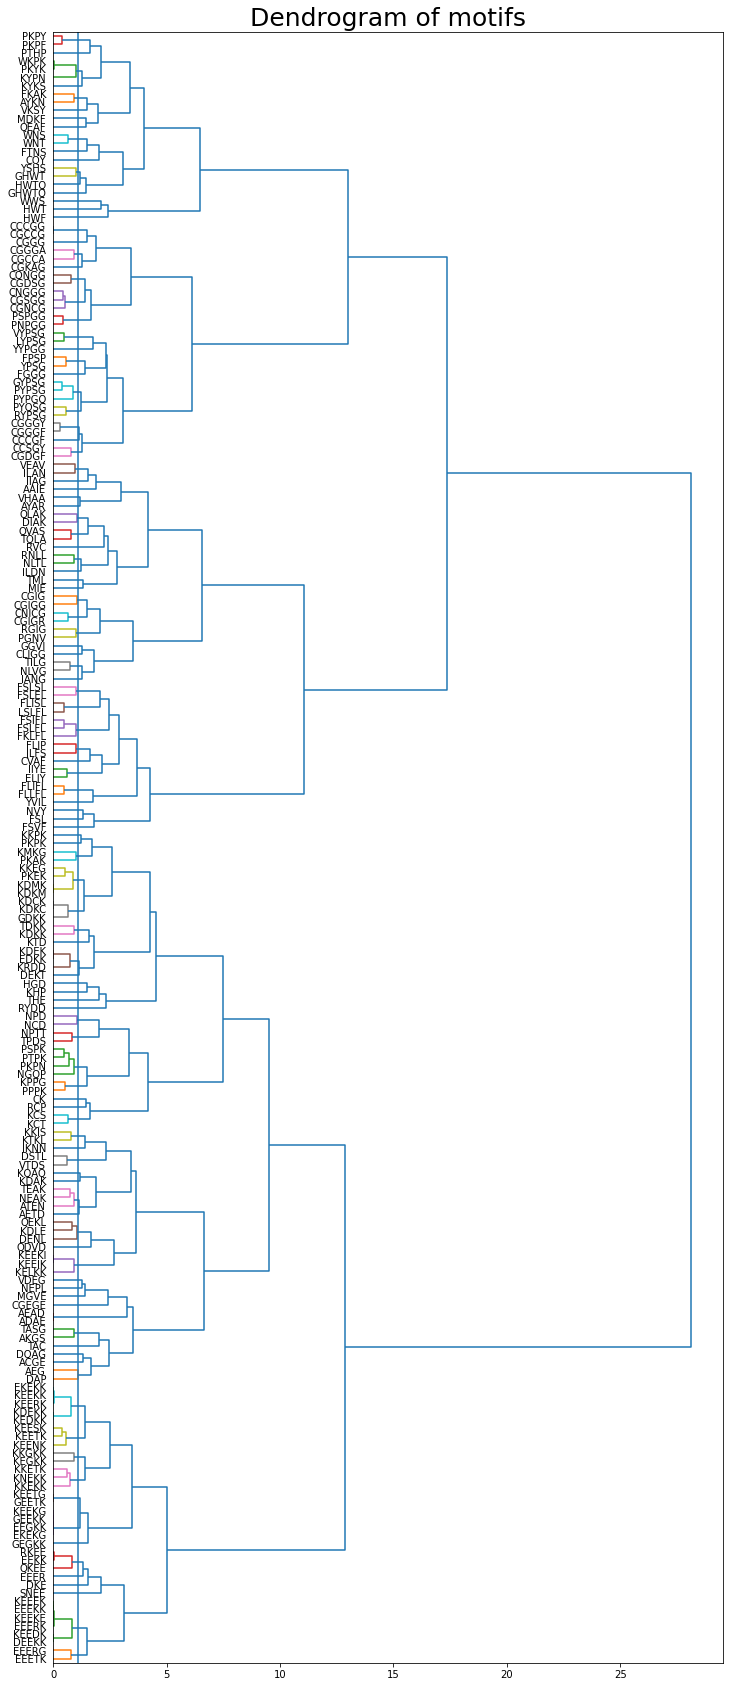

In [45]:
# 1000
link_matrix, best_distance, dict_davies_bouldin_results, df_motifs_CLUMPs, dendogram, newick_tree = motif_clustering(df_motifs_scl, 1000)

In [46]:
df_motifs_CLUMPs.CLUMP.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115])